<a href="https://colab.research.google.com/github/miguelamda/DeepLearningMII/blob/main/3_fundamentos_practicos/Practica_3.2_clasificacion_multiclase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 3.2. CLASIFICACIÓN MULTICLASE

En la práctica anterior vimos como trabajar de forma básica con tensores de PyTorch para entrenar un modelo lineal sobre el dataset MNIST. En esta práctica vamos a ver una forma sencilla de cargar datos pre-definidos y de crear modelos secuenciales (por capas) en PyTorch. Para ello, usaremos una serie de módulos y clases que son muy útiles para crear y entrenar redes neuronales en PyTorch: [torch.nn](https://pytorch.org/docs/stable/nn.html), [torch.optim](https://pytorch.org/docs/stable/optim.html), [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) y [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader). Iremos construyendo sobre estas partes, poco a poco, para ver qué hace cada una. Primero, carguemos `torch.nn`, `Dataset` y `DataLoader`.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

## 0. Objetivos

* Uso de **Torchvision** para datasets de imágenes
* Uso de `Dataset` concreto y creación de un `Dataloader`
* Creación de modelos con `nn.Sequential`
* Función de pérdida en clasificación multiclase y optimizador SGD.

## 1. Preparación de los datos

### 1.1. Descarga de los datos

Volveremos a trabajar con [MNIST](http://yann.lecun.com/exdb/mnist/), pero esta vez con los datos ya pre-procesados dentro de PyTorch. Este entorno tiene varias extensiones para trabajar con problemas de *visión* [torchvision](https://docs.pytorch.org/vision/stable/index.html), *audio* [torchaudio](https://docs.pytorch.org/audio/stable/index.html) y *texto* [torchtext](https://docs.pytorch.org/text/stable/index.html), entre otros. En nuestro caso, vamos a cargar MNIST desde la colección de [datasets de torchvision](https://docs.pytorch.org/vision/stable/datasets.html).

Para poder cargar los datos que trae de ejemplo torchvision hay que seguir dos pasos:
 * primero, cargar la librería torchvision que porporciona las herramientas para trabajar con el dataset concreto (que suelen estar en el paquete `torchvision.datasets`, en este caso llamado `MNIST`); y,
 * segundo, ejecutar el proceso de carga de los datos para el conjunto de entrenamiento y para el de test. Como es la primera vez que realizamos este proceso concreto, debemos indicar que queremos descargar los datos, ya que, debido a su tamaño, no se instalan por defecto junto con la librería:

In [ ]:
import torchvision

train_data = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_data = torchvision.datasets.MNIST("./data/", train=False, download=True)

# posiblemente veas abajo varios intentos de descarga

Podemos explorar un poco cómo son cada una de estas variables:

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

Tenemos para hacer entrenamiento un subconjunto de 60.000 imágenes. El conjunto de test, descargado así porque hemos dicho que `train=False`, lo usaremos para hacer validación, y como vemos abajo, tiene 10.000 imágenes.

In [ ]:
valid_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test

In [ ]:
len(valid_data)

10000

In [ ]:
x0, y0 = train_data[0]
print(type(x0))
print(type(y0))
print('la clase es ', y0)
print('el ejemplo es:')
x0

<class 'PIL.Image.Image'>
<class 'int'>
la clase es  5
el ejemplo es:


Habrás notado que las variables que contienen los conjuntos de train y valid no son tensores, sino unos objetos que contienen información de los datos (incluso la ruta donde está almacenado el dataset). En este caso, los datasets que podemos descargar de *torchvision* son subclases de `Dataset`.

Un **Dataset** puede ser cualquier clase que tenga predefinida los métodos `__getitem__` y `__len__`. Es por ello que hemos podido ejecutar sin problema las dos celdas anteriores.

### 1.2. Adaptación de los datos

Verás en la celda de código anterior que el valor X del ejemplo que hemos consultado es directamente una imagen, no un tensor. Y es de tipo entero, lo cual nos sirve para entrenamiento. Por tanto, si queremos recibir un tensor cada vez que indexemos el dataset, debemos transformarlo a tensor. Esto lo podemos hacer con una función que trae TorchVision para convertir de [imágenes PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html) a tensores con la clase [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html). Puedes ver más transformaciones en la [web](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
# importamos las librerías de transformaciones
import torchvision.transforms.v2 as transforms

In [ ]:
transforms.PILToTensor()(x0)

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

Bien, hemos convertido cada imagen a un tensor, sin embargo, los valores son enteros entre 0 y 255 (escala de grises). Estos valores, aunque numéricos, no son buenos para introducirlos en una red. Valores tan altos producirán más bien ruido, y afectando negativamente al entrenamiento (los valores de entrada se utilizarán para actualizar los pesos!). Es mejor que los valores estén en un rango entre 0 y 1, por lo que conviene normalizarlos. Esto lo podemos hacer con otra transformación, `ToDtype`. TorchVision nos provee un mecanismo sencillo para crear transformaciones que consiste en la concatenación de otras transformaciones, simplemente usando `Compose`:

In [ ]:
transf = transforms.Compose([transforms.PILToTensor(), transforms.ToDtype(torch.float32, scale=True)])

x0_transformado = transf(x0)[0] # solo la primera imagen
print(x0_transformado.shape) # tamaño de la imagen
x0_transformado

torch.Size([28, 28])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Hay muchas formas de aplicar transformaciones a un dataset. Quizás la más sencilla es asignar la transformación al miembro `transform` del objeto del dataset. Esto hará que cada vez que se acceda a un elemento del dataset, éste se devolverá después de aplicarle la transformación aportada.

In [ ]:
train_data.transform = transf
valid_data.transform = transf

type(train_data[0][0])

torch.Tensor

Aunque el objeto dataset (`train_data`, `valid_data`) sea iterable, necesitamos otro mecanismo para muestrear los ejemplos (en batches, de forma aleatoria, etc.). Para ello, podemos usar la clase [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders).

En el siguiente ejemplo, vamos a definir un tamaño de batch de 64, considerado un buen valor al ser potencia de 2 (así cómo también lo son 8, 16, 32 o 64), y no haremos recorrido aleatorio en validación ya que no lo usaremos para entrenar el modelo en sí. Con esto ya tenemos los datos listos para pasárselos a un modelo.

In [ ]:
batch = 1024

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch)

## 2. Definición del modelo

Ya estamos en condiciones de definir una red neuronal que consumirá los datos anteriores para ver si somos capaces de dar una primera solución al problema. Como solo estamos haciendo una primera aproximación a PyTorch, la red definida será básica que incluirá los siguientes cuatro elementos:

1. Un capa para aplanar ([Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)) los tensores n-dimensionales a vectores (1 dimensión).
2. La capa de entrada (784 neuronas)
3. Una capa oculta de 512 neuronas con función de activación ReLu
4. Una capa de salida (10 neuronas)

Esta vez vamos a usar un mecanismo en PyTorch que nos permitirá crear modelos secuenciales (apilación de una capa tras otra) de forma sencilla a partir de una lista. Además, esta librería nos provee de objetos que representan tipos de capas. Todo esto está incluido en la librería `torch.nn`.

Pero antes, vamos a ir añadiendo cada componente poco a poco:

In [ ]:
layers = []  #lista vacía

Primero, recuerda que cada ejemplo es un tensor de (28,28), es decir, de dos dimensiones. Una red perceptrón multicapa (MLP de las siglas en inglés) requiere conectar cada elemento con todas las neuronas de la siguiente capa. Es por ello que necesitamos que la entrada sea un vector, y esto lo conseguimos con `torch.nn.flatten`. En la práctica anterior no hizo falta ya que los datos ya venían en vectores de 1 dimensión de tamaño 728.

In [ ]:
layers.append(nn.Flatten())

Ahora, añadamos una capa oculta. Como vimos en la práctica anterior, una capa MLP es simplemente una combinación lineal. Esto ya lo tenemos disponible en `torch.nn.linear`. Esta capa requiere que le indiquemos:
* el número de entradas: el número de neuronas en la capa anterior. En nuestro ejemplo, la capa de entrada, 784.
* el número de salidas: el número de neuronas de la capa que estamos representando (ya que cada neurona participa en la salida). En nuestro caso, al ser la capa oculta, 512.

In [ ]:
layers.append(nn.Linear(784,512))

La capa anterior no tiene asignada una función de activación. Debemos definirla como otra "capa" después de la anterior. En nuestro caso ReLU.

In [ ]:
layers.append(nn.ReLU())

Para la capa de salida vamos a introducir una capa MLP, sin definir una función de activación.

**Ejercicio:** Añade una capa MLP para la capa de salida.

In [ ]:
# Ejercicio
layers.append(nn.Linear(FIXME,FIXME))

In [ ]:
# @title
# Solución
layers.append(nn.Linear(512,10))

In [ ]:
# En resumen tenemos:
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

Por ahora solo tenemos una lista de capas. Construyamos un modelo  con [nn.sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), el cual espera una secuencia de argumentos, por lo que podeomos usar el [operador *](https://docs.python.org/3/reference/expressions.html#expression-lists) para desempaquetar una lista.

In [ ]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=10, bias=True)
)

## 3. Proceso de entrenamiento

Vamos a definir las partes necesarias para realizar el entrenamiento.

### 3.1. Función de pérdida, optimizador y métrica

Cuando trabajamos con problemas de clasificación multiclase, la elección de la función de pérdida es crucial. En PyTorch, dos de las opciones más comunes son [`NLLLoss`]((https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)) (Negative Log Likelihood Loss, la que implementamos a mano en la práctica anterior) y [`CrossEntropyLoss`]((https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

`NLLLoss` se utiliza cuando la salida de nuestra red neuronal ya ha pasado por una función de activación como **LogSoftmax**. Sin embargo, la práctica estándar y preferida es usar `CrossEntropyLoss`. La principal diferencia es que **`CrossEntropyLoss` realiza la operación de `LogSoftmax` internamente y luego emplea `NLLLoss`**, lo que elimina la necesidad de aplicarla explícitamente a la capa de salida de nuestra red. Esto significa que, en lugar de alimentar a la función de pérdida con probabilidades, le proporcionamos directamente los **logits** (las salidas sin procesar de la última capa de la red). Esta forma de trabajar tiene sus ventajas:

* **Eficiencia y estabilidad numérica**: La combinación de las operaciones de `log` y `softmax` en una sola función optimizada (como `LogSoftmax`) es mucho más estable y eficiente desde el punto de vista computacional. Esto previene problemas numéricos como el *underflow* que pueden ocurrir al calcular el logaritmo de valores muy pequeños.

* **Simplificación del flujo de trabajo**: Al no tener que añadir una capa de `Softmax` al final de la red, nuestro código se vuelve más limpio y fácil de manejar. La función de pérdida se encarga de la parte matemática del cálculo de la probabilidad.

* **Predicción (`Inference`)**: Un punto clave es que para hacer una predicción final (una vez que el modelo está entrenado), no necesitamos la función `softmax`. Para determinar la clase predicha, simplemente necesitamos encontrar el índice del valor más alto en el vector de *logits*. La función **`argmax`** se encarga de esto, ya que el orden de los valores de los logits es el mismo que el de las probabilidades después de aplicar `softmax`. Esto se debe a que `softmax` es una función **monotónica**, por lo que preserva el orden de las entradas.

In [ ]:
loss_func = nn.CrossEntropyLoss()

Ahora, definimos el **optimizador** para actualizar los parámetros de nuestro modelo. PyTorch ya tiene muchos predefinidos en [torch.optim](https://docs.pytorch.org/docs/stable/optim.html), por lo que no hace falta implementar la regla de actualización de los pesos a mano, como hicimos en la práctica. En concreto, vamos a usar `SGD` con *momentum*. Hay que indicarle al optimizador, a la hora de crearlo, los parámetros del modelo, ya que será el optimizador quien se encargue de modificarlos (una vez se hayan propagado los gradientes). Además, opcionalmente, le podemos pasar otros hiperparámetros como el learning rate, o en este caso, el valor de momentum.

In [ ]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)


Y por último, vamos a usar como métrica el accuracy, ya que la función de pérdida no estan tan interpetable por humanos.

**Ejercicio**: La función accuracy hay que definirla a mano, ya que PyTorch no la provee (aunque sí viene en otras librerías como torchmetrics). Reemplaza los FIXME a continuación.

In [ ]:
def accuracy(out, yb):
    # la predicción es la clase del valor más alto
    # como tenemos un batch, hay que aplicarlo a través de la dimensión de cada ejemplo
    preds = torch.FIXME(out, dim=FIXME)
    return (preds == yb).float().FIXME().FIXME()

In [ ]:
# @title
# Solución
def accuracy(out, yb):
    # la predicción es la clase del valor más alto
    # como tenemos un batch, hay que aplicarlo a través de la dimensión de cada ejemplo
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean().item()

### 3.2 Bucle de entrenamiento

El siguiente código muestra cómo queda el bucle de entrenamiento y el de validación con estos nuevos elementos de PyTorch.

**Ejercicio**. Observa el código y comprueba las diferencias con respecto a lo que hicimos en la práctica anterior. Después del código podrás ver un resumen de las diferencias principales.

In [ ]:
def train():
    lossAcum = 0
    accuAcum = 0

    model.train()              # ponemos al modelo en modo train
    for x, y in train_loader:  # iteramos sobre el dataset
        optimizer.zero_grad()  # reseteo gradientes
        pred = model(x)        # forward pass
        batch_loss = loss_func(pred, y)   # función de pérdida
        batch_loss.backward()  # backward pass
        optimizer.step()       # actualización de los pesos

        lossAcum += batch_loss.item()
        accuAcum += accuracy(pred, y)

    print('Entrenamiento - Loss: {:.4f} Accuracy: {:.4f}'.format(lossAcum/len(train_loader), accuAcum/len(train_loader)))

In [ ]:
def validate():
    lossAcum = 0
    accuAcum = 0

    model.eval()                   # ponemos al modelo en modo train
    with torch.no_grad():          # no trackeamos los gradientes a continuación
        for x, y in valid_loader:  # iteramos el dataset
            pred = model(x)      # inferencia del modelo sobre x

            lossAcum += loss_func(pred, y).item()
            accuAcum += accuracy(pred, y)
    print('Validación - Loss: {:.4f} Accuracy: {:.4f}'.format(lossAcum/len(valid_loader), accuAcum/len(valid_loader)))

¿Puedes ver las diferencias con respecto al bucle de la práctica anterior?
* Los modelos creados con `torch.nn` tienen dos modos para trabajar, en modo *train* y en modo *eval*. Ciertas capas, como las de normalización y las de dropout, se comportan de forma distinta cuando están siendo entrenadas a cuando se usan para inferencia, y estos modos las prepara para cada ocasión.
* El recorrido de los batches se hace mucho más sencillo con `DataLoader`, quedando en tan solo un bucle con iteradores x e y. Ya hemos definido previamente el tipo de recorrido, tamaño de batch, y las transformaciones aplicadas a los datos.
* Tenemos un objeto `optimizer` usado en `train()` para actualizar los pesos. Este objeto calcula los gradientes aplicados a cada parámetro del modelo (recuerda que se los pasamos cuando lo creamos). Sin embargo, PyTorch permite acumular los gradientes de batch a otro, para permitir configuraciones avanzadas, por lo que para nuestro caso más simple, debemos resetear los gradientes en cada batch (recuerda: el gradiente lo calculamos para cada batch, y es el que se usa para hacer la actualización de pesos). Después de retropropagar los gradientes, podemos dar un paso (`step`), es decir, actualizar los parámetros.

Finalmente, tenemos el bucle de entrenamiento, que quedaría igual que antes. Esta vez vamos a hacer cinco épocas, y hemos añadido en la primera línea una función mágica de Jupyter que nos permite medir el tiempo de ejecución de toda la celda. Podrás ver que la ejecución de la celda tarda bastante, por supuesto dependiendo de la velocidad de tu CPU. Si has hecho al menos una época pero ha tardado mucho, te aconsejo parar la ejecución de la celda y reducir el número de épocas.

In [ ]:
%%time

epochs = 5

for epoch in range(epochs):
    print('Epoch: ', epoch)
    train()
    validate()

Epoch:  0
Entrenamiento - Loss: 2.3202 Accuracy: 0.0744
Validación - Loss: 2.3207 Accuracy: 0.0761
Epoch:  1
Entrenamiento - Loss: 2.3202 Accuracy: 0.0746
Validación - Loss: 2.3207 Accuracy: 0.0761
Epoch:  2
Entrenamiento - Loss: 2.3202 Accuracy: 0.0745
Validación - Loss: 2.3207 Accuracy: 0.0761
Epoch:  3
Entrenamiento - Loss: 2.3202 Accuracy: 0.0744
Validación - Loss: 2.3207 Accuracy: 0.0761
Epoch:  4
Entrenamiento - Loss: 2.3202 Accuracy: 0.0745
Validación - Loss: 2.3207 Accuracy: 0.0761
CPU times: user 1min 4s, sys: 187 ms, total: 1min 5s
Wall time: 34.1 s


Debemos tener en cuenta que los valores mostrados son el error y métricas calculados sobre los propios datos de entrenamiento junto con los de validación (recuerda, son ejemplos que no ha usado para ajustarse).

Sobre los datos de entrenamiento alcanzamos rápidamente una precisión de 0.9 (es decir, 90%), y en validación un 0.91. Lo normal es que la red se comporte peor en los datos de validación que en los datos de entrenamiento, ya que el proceso de entrenamiento consiste precisamente en ajustar los pesos para que el error cometido en estos últimos se minimice. Esta diferencia de comportamiento entre entrenamiento y test se denomina **overfitting** (o **sobreajuste**). En todo caso, con una red tan simple como la que hemos usado, se alcanzan cotas de casi el 93% de aciertos, por lo que no llegamos a ver este fenómeno en un número limitado de épocas.

Recuerda que tan solo hemos añadido una capa oculta con respecto al modelo de la práctica anterior, lo cual ha incrementado 51 veces en complejidad. El modelo lineal tenía $784*10 = 7.840$ parámetros, mientras que ahora tenemos $784*512 + 512*10 = 406.528$. Además, usamos un optimizador con momentum, y recorremos el dataset de forma aleatoria.

Finalmente, podemos ver las predicciones que hace la red sobre algunos datos del conjunto de test, y comprobamos cómo de acertado está según la etiqueta real. Puedes jugar con `i` para ver el resultado con otro ejemplo del conjunto de test.

6

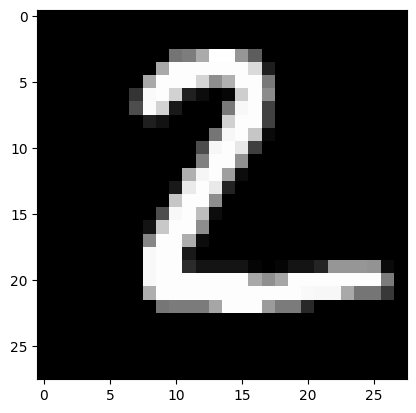

In [ ]:
import matplotlib.pyplot as plt

x,y = valid_data[1]
image = transforms.ToPILImage()(x)
plt.imshow(image, cmap='gray')

pred = model(x)
pred.argmax(1).item()

In [ ]:
import matplotlib.pyplot as plt

def muestra_imagen_prediccion(i):
    # obtenemos datos del dataset en posición i
    x,y = valid_data[i]
    # transformamos a imagen
    image = transforms.ToPILImage()(x)
    # mostramos la imagen en grande
    plt.imshow(image, cmap='gray')
    plt.show()
    # mostrar la etiqueta
    print("Etiqueta numérica:   ", y)
    # hacemos inferencia
    pred = model(x)
    print("Predicción:          ", pred.argmax(1).item())

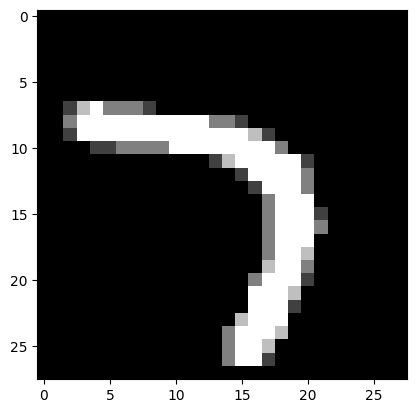

Etiqueta numérica:    7
Predicción:           5


In [ ]:
x = 60 # prueba aquí otro número para ver otro ejemplo
muestra_imagen_prediccion(x)

Puedes usar el siguiente código para ver `k` ejemplos mal predichos.

Elemento:             0


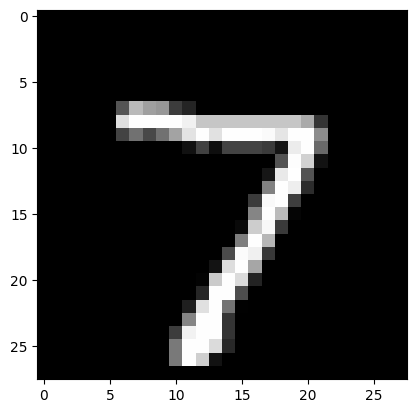

Etiqueta numérica:    7
Predicción:           0
----------------------
Elemento:             1


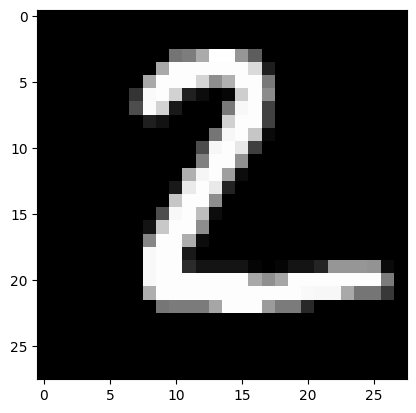

Etiqueta numérica:    2
Predicción:           6
----------------------
Elemento:             2


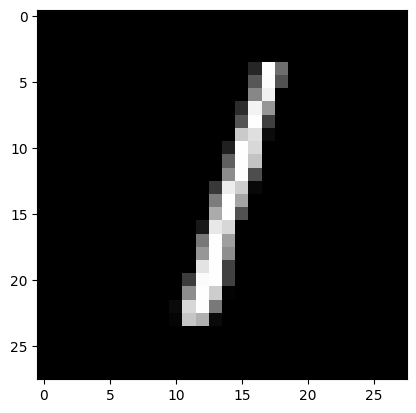

Etiqueta numérica:    1
Predicción:           3
----------------------
Elemento:             3


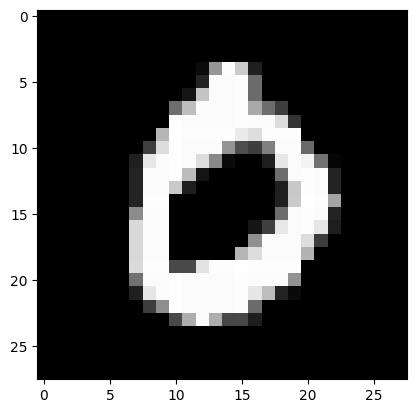

Etiqueta numérica:    0
Predicción:           7
----------------------


In [ ]:
k=4
for i in range(0,len(valid_data)):
    x,y = valid_data[i]
    pred = model(x)
    if pred.argmax(1).item() != y:
        k=k-1
        if k<0:
            break;
        print ("Elemento:            ",i)
        muestra_imagen_prediccion(i)
        print("----------------------")

## 5. Ejercicio Opcional Propuesto

Juega con el entrenamiento del modelo para ver qué resultados obtienes y si consigues mejorar (o por el contrario se empeora el resultado):
* cambia el método de [optimización](https://docs.pytorch.org/docs/stable/optim.html),
* cambia el learning rate
* amplía el número de epochs,
* añade o quita capas,
* cambia las [funciones de activación](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity),
* ¿Otra idea?

## 6. Bibliografía

* [Tutorial de PyTorch](https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html), Jeremy Howard.
* [Fundamentals of Deep Learning](https://github.com/hongbo-wei/NVIDIA-Fundamentals-of-Deep-Learning/blob/main/workshop-DLI/01_mnist.ipynb), NVIDIA Deep Learning Institute.
* [Deep Learning with PyTorch](https://www.manning.com/books/deep-learning-with-pytorch), Eli Stevens, Luca Antiga, Thomas Viehmann.
* [Deep Learning with Python](https://deeplearningwithpython.io/chapters/), François Chollet, Matthew Watson